# load the data

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np 

# Load your datasets
pre_treatment_data = pd.read_csv(r"ACMEOrdersData.csv", parse_dates=['Week'])
treatment_data = pd.read_csv(r"orders_treatment_period.csv", parse_dates=['Week'])

treatment_geos = ['Missouri', 'Montana', 'New Mexico', 'Tennessee']
unavailable_states = ['Delaware', 'Kansas', 'Kentucky', 'Arkansas', 'Mississippi']

# Prepare the data by excluding the 'Week' column and ensuring numeric data
pre_treatment_data_numeric = pre_treatment_data.drop(columns=['Week']).select_dtypes(include=[np.number])
treatment_data_numeric = treatment_data.drop(columns=['Week']).select_dtypes(include=[np.number])

# Update control geos to exclude any states not present in the treatment_data
control_geos = [geo for geo in pre_treatment_data_numeric.columns if geo not in treatment_geos + unavailable_states]

# Aggregate pre-treatment sales for the treatment geos
Y_all_treatment = pre_treatment_data_numeric[treatment_geos].sum(axis=1)

# Use the numeric control geos for the independent variables
X_control = pre_treatment_data_numeric[control_geos]

/var/folders/zy/p5j6wn6j00vcc4x_6035nhcc0000gn/T/ipykernel_95544/994376291.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pre_treatment_data = pd.read_csv(r"ACMEOrdersData.csv", parse_dates=['Week'])


# choose geos 

In [2]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

lasso_cv = LassoCV(cv=5, random_state=42).fit(X_control, Y_all_treatment)
# The best alpha found by cross-validation
best_alpha = lasso_cv.alpha_

# LassoCV automatically uses the best alpha, so it has already selected features
# Features with non-zero coefficients are considered selected by the model

# Get the coefficients
coefficients = lasso_cv.coef_

# Identify non-zero coefficients (i.e., selected features)
selected_features_bool = coefficients != 0
selected_features = [control_geos[i] for i, selected in enumerate(selected_features_bool) if selected]

# For interpretability, you might still want to see which features were deemed most important
feature_importance = abs(coefficients[selected_features_bool])
important_features_sorted = sorted(zip(selected_features, feature_importance), key=lambda x: x[1], reverse=True)

# Display the features selected by LassoCV
print("Features selected by LassoCV:")
for feature, importance in important_features_sorted:
    print(f"Feature: {feature}, Importance: {importance}")

# Use only the selected features for further analysis
X_control_selected = X_control[selected_features]
X_control_selected

Features selected by LassoCV:
Feature: Pennsylvania, Importance: 0.2328350210740405
Feature: Texas, Importance: 0.21586909142770103
Feature: Ohio, Importance: 0.2095098230685997
Feature: North Carolina, Importance: 0.17524096338482673
Feature: Florida, Importance: 0.05192843805085734
Feature: Oregon, Importance: 0.028064530645717733


,Florida,North Carolina,Ohio,Oregon,Pennsylvania,Texas
0,15513,6173,5678,2740,6847,11850
1,18418,6807,6418,3559,7882,13983
2,18101,7051,6210,3347,7631,13918
3,18282,7075,6033,3402,7821,13902
4,17538,6746,5775,3109,7242,13345
...,...,...,...,...,...,...
99,18246,6741,6766,4496,8405,15173
100,16801,6670,6683,4984,8281,14477
101,18488,6915,6682,4108,8562,15646
102,9057,3247,2834,2296,3296,7640


# create geos groups 

In [3]:
treatment_data[selected_features]

,Florida,North Carolina,Ohio,Oregon,Pennsylvania,Texas
0,14274,5016,4647,3603,5502,10706
1,15595,5524,5276,3970,6399,12497
2,15907,5806,5159,3879,6463,12807
3,15767,5681,4985,4346,6120,12122


In [4]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Fit a linear regression model using the selected features
model = LinearRegression().fit(X_control_selected, Y_all_treatment)


# Prepare the treatment data
X_treatment = treatment_data[selected_features].values  # Ensure this uses numeric data

# Predict synthetic control for pre-treatment and treatment periods
synthetic_control_pre_treatment = model.predict(X_control_selected)
synthetic_control_treatment = model.predict(X_treatment)

# Aggregate actual sales for all treatment geos
actual_sales_pre_treatment = pre_treatment_data[treatment_geos].sum(axis=1).values
actual_sales_treatment = treatment_data[treatment_geos].sum(axis=1).values


# Calculate the causal effect
causal_effect = actual_sales_treatment - synthetic_control_treatment

# Summarize the causal effect
average_causal_effect = np.sum(causal_effect)/4
total_causal_effect = np.sum(causal_effect)

# Displaying the summarized effects
print(f"Average causal effect: {average_causal_effect}")
print(f"Total causal effect: {total_causal_effect}")

Average causal effect: -1454.9032615741392
Total causal effect: -5819.613046296557


/Users/Icy/anaconda3/envs/regression/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [5]:
from scipy.stats import ttest_rel

# Perform the paired t-test
t_statistic, p_value = ttest_rel(actual_sales_treatment, synthetic_control_treatment)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation of the results
if p_value < 0.05:
    print("There is a statistically significant difference between the treatment and control groups.")
else:
    print("There is no statistically significant difference between the treatment and control groups.")


T-statistic: -9.65855827518984
P-value: 0.0023562599418437526
There is a statistically significant difference between the treatment and control groups.


In [6]:
# Combine synthetic control predictions
synthetic_control_combined = np.concatenate([synthetic_control_pre_treatment, synthetic_control_treatment])

# Combine actual sales data for comparison
actual_sales_combined = np.concatenate([actual_sales_pre_treatment, actual_sales_treatment])

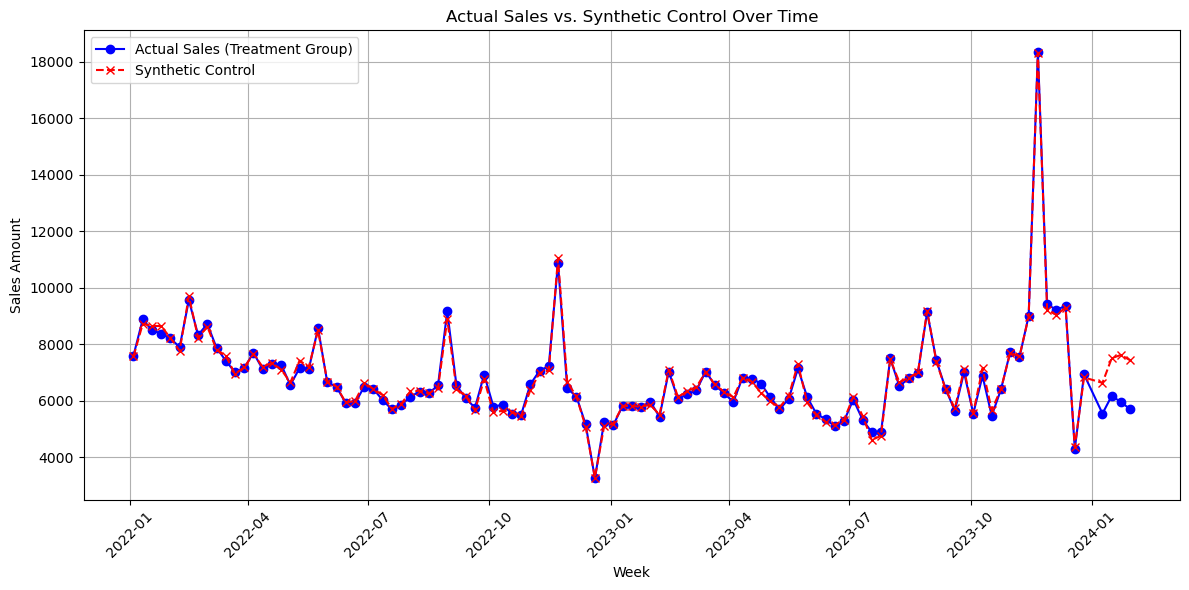

In [7]:
import matplotlib.pyplot as plt
weeks_pre_treatment = pd.to_datetime(pre_treatment_data['Week'])
weeks_treatment = pd.to_datetime(treatment_data['Week'])
weeks_combined = pd.concat([weeks_pre_treatment, weeks_treatment])

plt.figure(figsize=(12, 6))

# Plot actual sales
plt.plot(weeks_combined, actual_sales_combined, label='Actual Sales (Treatment Group)', color='blue', marker='o')

# Plot synthetic control
plt.plot(weeks_combined, synthetic_control_combined, label='Synthetic Control', color='red', linestyle='--', marker='x')

plt.title('Actual Sales vs. Synthetic Control Over Time')
plt.xlabel('Week')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True)

# Rotate date labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## infer national treatment effect

In [8]:
# fit a linear regression model for national sales using the treatment geos, for pre-treatment period
Y_national = pre_treatment_data_numeric.sum(axis=1)
X_treatment = pre_treatment_data_numeric[treatment_geos].sum(axis=1).values.reshape(-1, 1)

import statsmodels.api as sm
model = sm.OLS(Y_national, sm.add_constant(X_treatment)).fit()

#print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.103e+04
Date:                Fri, 12 Apr 2024   Prob (F-statistic):          8.96e-106
Time:                        22:32:33   Log-Likelihood:                -1002.7
No. Observations:                 104   AIC:                             2009.
Df Residuals:                     102   BIC:                             2015.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5464.6932   1532.389     -3.566      0.0

In [9]:
# Predict national treatment effect
national_treatment_effect = model.predict(sm.add_constant(causal_effect.reshape(-1, 1)))
national_treatment_effect

array([-30403.0173362 , -36034.60498656, -43747.05057861, -45177.10310293])